In [1]:
import sys
sys.path.append("C:/Users/msachde1/Downloads/Research/Development/mgwr")

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from mgwr.gwr import GWR
from spglm.family import Gaussian, Binomial, Poisson
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
import multiprocessing as mp
pool = mp.Pool()
from scipy import linalg
import numpy.linalg as la
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from spreg.utils import spdot, spmultiply
from scipy import special
import libpysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import copy
from collections import namedtuple
import spglm

### Simulated data for Binomial MGWR

### Global Example

In [3]:
x = np.linspace(0, 25, 25)
y = np.linspace(25, 0, 25)
X, Y = np.meshgrid(x, y)

lon = X.reshape(-1,1)
lat = Y.reshape(-1,1)

coords = np.array(list(zip(lon,lat)))

In [4]:
x1=np.random.normal(0,1,625)
x2=np.random.normal(0,1,625)
error = np.random.normal(0,0.1,625)

z = 1+2*x1+3*x2+error

x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)

pr = 1/(1+np.exp(-z))

In [5]:
y = np.random.binomial(1,pr)
X = np.hstack([x1,x2])
y = np.array(y).reshape((-1,1))

In [6]:
bw = Sel_BW(coords,y,X,family=Binomial())
bw=bw.search()

In [7]:
gwr_mod = GWR(coords, y, X, bw,family=Binomial()).fit()

### MGWR

In [8]:
selector = Sel_BW(coords,y,X,multi=True,family=Binomial())
selector.search(verbose=True,max_iter_multi=50)

Current iteration: 1 ,SOC: 0.0450537
Bandwidths: 519.0, 624.0, 183.0
Current iteration: 2 ,SOC: 0.020152
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 3 ,SOC: 0.0032721
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 4 ,SOC: 8.01e-05
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 5 ,SOC: 9.37e-05
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 6 ,SOC: 3.74e-05
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 7 ,SOC: 1.87e-05
Bandwidths: 519.0, 624.0, 624.0
Current iteration: 8 ,SOC: 9e-06
Bandwidths: 519.0, 624.0, 624.0


array([519., 624., 624.])

In [9]:
mgwr_mod = MGWR(coords, y, X, selector,family=Binomial()).fit()

In [10]:
np.mean(gwr_mod.params,axis=0), np.mean(mgwr_mod.params,axis=0)

(array([1.16604381, 2.24362744, 3.27846807]),
 array([0.70461953, 1.78115408, 2.84722997]))

In [11]:
gwr_mod.aic, mgwr_mod.aic

(357.9759977731823, 363.5967703986909)

### Local surface example

##### Forming variables

In [12]:
def add(a,b):
    return 1+((1/12)*(a+b))

def con(u,v):
    return (0*(u)*(v))+1

def sp(u,v):
    return 1+1/324*(36-(6-u/2)**2)*(36-(6-v/2)**2)

def med(u,v):
    B = np.zeros((25,25))
    for i in range(25):
        for j in range(25):
            
            if u[i][j]<=8:
                B[i][j]=0.2
            elif u[i][j]>17:
                B[i][j]=0.7
            else:
                B[i][j]=0.5
    return B

In [13]:
x = np.linspace(0, 25, 25)
y = np.linspace(25, 0, 25)
X, Y = np.meshgrid(x, y)

In [14]:
x1=np.random.normal(0,1,625)
x2=np.random.normal(0,1,625)
error = np.random.normal(0,0.1,625)
#error =error-min(error)

In [15]:
B0=con(X,Y)
B1=sp(X,Y)
B2=med(X,Y)

([], <a list of 0 Text yticklabel objects>)

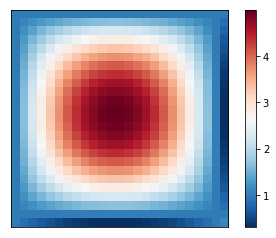

In [16]:
plt.imshow(B1, extent=[0,10, 0, 10], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

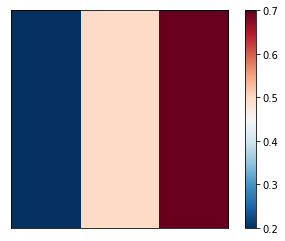

In [17]:
plt.imshow(B2, extent=[0,25, 0, 25], origin='lower',cmap='RdBu_r')
plt.colorbar()
plt.axis(aspect='image')
plt.xticks([])
plt.yticks([])

In [18]:
B0=B0.reshape(-1,1)
B1=B1.reshape(-1,1)
B2=B2.reshape(-1,1)

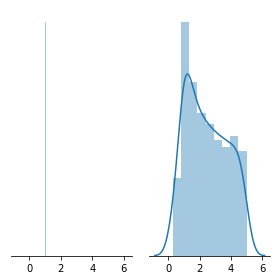

In [19]:
f, axes = plt.subplots(1, 2, figsize=(4, 4), sharex=True)
sns.despine(left=True)
sns.distplot(B0,ax=axes[0])
sns.distplot(B1,ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

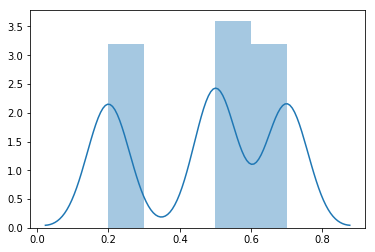

In [20]:
sns.distplot(B2)

In [21]:
lat=Y.reshape(-1,1)
lon=X.reshape(-1,1)

In [22]:
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)

In [23]:
param = np.hstack([B0,B1,B2])

In [24]:
param.shape

(625, 3)

In [25]:
cons=np.ones_like(x1)

In [26]:
cons=cons.reshape(-1,1)

In [27]:
X=np.hstack([cons,x1,x2])

In [28]:
X.shape

(625, 3)

In [29]:
#binomial y
y_exp=((np.exp(np.sum(X * param, axis=1)+error)/(1+(np.exp(np.sum(X * param, axis=1)+error))))).reshape(-1,1)

In [30]:
np.mean(y_exp)

0.6510162481437103

In [31]:
y_exp.shape

(625, 1)

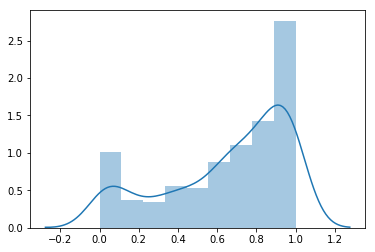

In [32]:
sns.distplot(y_exp)

In [33]:
y = np.random.binomial(1,y_exp)

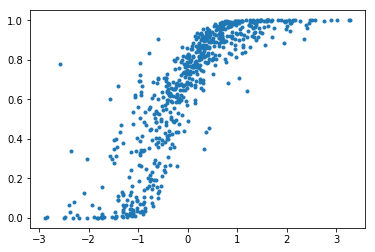

In [34]:
pd.Series(y_exp.reshape(-1), index=x1).plot(style='.')

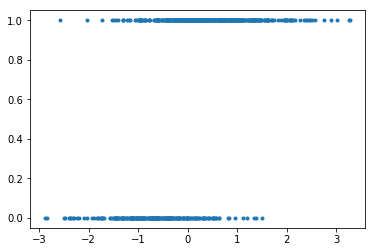

In [35]:
pd.Series(y.reshape(-1), index=x1).plot(style='.')

In [36]:
coords = np.array(list(zip(lon,lat)))
y = np.array(y).reshape((-1,1))
#y_std = (y-y.mean(axis=0))/y.std(axis=0)

In [37]:
X=np.hstack([x1,x2])
#X_std = (X-X.mean(axis=0))/X.std(axis=0)

In [38]:
bw=Sel_BW(coords,y,X,family=Binomial())
bw=bw.search()
gwr_model=GWR(coords,y,X,bw,family=Binomial()).fit()

In [39]:
bw

172.0

In [40]:
gwr_model.aic

564.9462195662602

In [41]:
selector=Sel_BW(coords,y,X,multi=True,family=Binomial())

In [42]:
selector.search(verbose=True)

Current iteration: 1 ,SOC: 0.0161926
Bandwidths: 622.0, 73.0, 170.0
Current iteration: 2 ,SOC: 0.0316518
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 3 ,SOC: 0.0039268
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 4 ,SOC: 0.0001849
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 5 ,SOC: 0.0001914
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 6 ,SOC: 8.61e-05
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 7 ,SOC: 4.99e-05
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 8 ,SOC: 2.72e-05
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 9 ,SOC: 1.62e-05
Bandwidths: 622.0, 181.0, 188.0
Current iteration: 10 ,SOC: 9.5e-06
Bandwidths: 622.0, 181.0, 188.0


array([622., 181., 188.])

In [43]:
mgwr_model=MGWR(coords,y,X,selector,family=Binomial()).fit()

In [44]:
np.mean(mgwr_model.params,axis=0),np.mean(gwr_model.params,axis=0)

(array([1.10211344, 2.53539688, 0.28485419]),
 array([0.90342461, 2.26934826, 0.25936595]))

In [45]:
np.mean(B0),np.mean(B1),np.mean(B2)

(1.0, 2.471045176769571, 0.468)

In [46]:
mgwr_model.aicc,gwr_model.aicc

(558.2437551708874, 567.8076915280018)